In [17]:
# -*- coding: utf-8 -*-
# doDMRG_MPO.py
import numpy as np
import jax
from numpy import linalg as LA
from ncon_jax import ncon
import tensornetwork as tn
#from tensornetwork.ncon_interface import ncon

tn.set_default_backend("jax")


def doDMRG_MPO(A,MLarr,Marr,MRarr,cH,Msigma,cs,Mtr,ctr,chi, numsweeps = 10, dispon = 2, updateon = True, maxit = 2, krydim = 4):
    tn.set_default_backend("jax")
    """
------------------------
by Glen Evenbly (c) for www.tensors.net, (v1.1) - last modified 19/1/2019
------------------------
Implementation of DMRG for a 1D chain with open boundaries, using the \
two-site update strategy. Each update is accomplished using a custom \
implementation of the Lanczos iteration to find (an approximation to) the \
ground state of the superblock Hamiltonian. Input 'A' is containing the MPS \
tensors whose length is equal to that of the 1D lattice. The Hamiltonian is \
specified by an MPO with 'ML' and 'MR' the tensors at the left and right \
boundaries, and 'M' the bulk MPO tensor. Automatically grow the MPS bond \
dimension to maximum dimension 'chi'. Outputs 'A' and 'B' are arrays of the \
MPS tensors in left and right orthogonal form respectively, while 'sWeight' \
is an array of the Schmidt coefficients across different lattice positions. \
'Ekeep' is a vector describing the energy at each update step.

Optional arguments:
`numsweeps::Integer=10`: number of DMRG sweeps
`dispon::Integer=2`: print data never [0], after each sweep [1], each step [2]
`updateon::Bool=true`: enable or disable tensor updates
`maxit::Integer=2`: number of iterations of Lanczos method for each diagonalization
`krydim::Integer=4`: maximum dimension of Krylov space in superblock diagonalization
"""
        
    
    QH = len(Marr)
    Qs = len(Msigma)
    
    
    ##### left-to-right 'warmup', put MPS in right orthogonal form
    chid = Marr[0].shape[2] #local dimension (физическая размерность, сверху вниз)
    Nsites = len(A)
    
    LHarr=[]
    RHarr=[]
    Lsigmaarr=[]
    Rsigmaarr=[]
    
    
    for i in range(QH):
        L = [0 for x in range(Nsites)];
        R = [0 for x in range(Nsites)];
        L[0] = MLarr[i]
        R[Nsites-1] = MRarr[i]
        LHarr.append(L)
        RHarr.append(R)
    
    for i in range(Qs):
        L = [0 for x in range(Nsites)];
        R = [0 for x in range(Nsites)];
        Lsigmaarr.append(L)
        Rsigmaarr.append(R)
        
    Ltr = [0 for x in range(Nsites)];
    Rtr = [0 for x in range(Nsites)];

        
    for p in range(Nsites-1):
        chil = A[p].shape[0]; chir = A[p].shape[2]
        utemp, stemp, vhtemp = LA.svd(A[p].reshape(chil*chid,chir), full_matrices=False)
        A[p] = utemp.reshape(chil,chid,chir)
        A[p+1] = ncon([np.diag(stemp) @ vhtemp,A[p+1]], [[-1,1],[1,-2,-3]])/LA.norm(stemp)
        
        for i in range(QH):
            LHarr[i][p+1] = ncon([LHarr[i][p],Marr[i],A[p],np.conj(A[p])],[[2,1,4],[2,-1,3,5],[4,5,-3],[1,3,-2]])
        
        for i in range(Qs):
            if p==0:
                Lsigmaarr[i][1] = ncon([A[0].reshape(chid,chir),np.conj(A[0]).reshape(chid,chir)],[[1,-1],[1,-2]])
            else:
                Lsigmaarr[i][p+1] = ncon([Lsigmaarr[i][p],A[p],np.conj(A[p])],[[1,2],[2,3,-2],[1,3,-1]])
                
        if p==0:
            Ltr[1] = ncon([A[0].reshape(chid,chir),np.conj(A[0]).reshape(chid,chir),Mtr],[[2,-2],[1,-1],[1,2]])
        else:
            Ltr[p+1] = ncon([Ltr[p],Mtr,A[p],np.conj(A[p])],[[1,2],[3,4],[2,4,-2],[1,3,-1]])
        
    
    
    
    chil = A[Nsites-1].shape[0]; chir = A[Nsites-1].shape[2]
    utemp, stemp, vhtemp = LA.svd(A[Nsites-1].reshape(chil*chid,chir), full_matrices=False)
    A[Nsites-1] = utemp.reshape(chil,chid,chir)
    sWeight = [0 for x in range(Nsites+1)]
    sWeight[Nsites] = (np.diag(stemp) @ vhtemp) / LA.norm(stemp)
    
    Ekeep = np.array([])
    EkeepSweep = np.array([])
    B = [0 for x in range(Nsites)]
    for k in range(1,numsweeps+2):
        
        ##### final sweep is only for orthogonalization (disable updates)
        if k == numsweeps+1:
            updateon = False
            dispon = 0
        
        ###### Optimization sweep: right-to-left
        for p in range(Nsites-2,-1,-1):
        
            ##### two-site update
            chil = A[p].shape[0]; chir = A[p+1].shape[2]
            psiGround = ncon([A[p],A[p+1],sWeight[p+2]],[[-1,-2,1],[1,-3,2],[2,-4]]).reshape(chil*chid*chid*chir)
            if updateon:
                psiGround, Entemp = eigLanczos(psiGround,doApplyMPO,(p,LHarr,RHarr,Lsigmaarr,Rsigmaarr,Ltr,Rtr,MLarr,Marr,MRarr,cH,Msigma,cs,Mtr,ctr), maxit = maxit, krydim = krydim)
                Ekeep = np.append(Ekeep,Entemp)
            
            utemp, stemp, vhtemp = LA.svd(psiGround.reshape(chil*chid,chid*chir), full_matrices=False)
            chitemp = min(len(stemp),chi)
            A[p] = utemp[:,range(chitemp)].reshape(chil,chid,chitemp)
            sWeight[p+1] = np.diag(stemp[range(chitemp)]/LA.norm(stemp[range(chitemp)]))
            B[p+1] = vhtemp[range(chitemp),:].reshape(chitemp,chid,chir)
            
            ##### new block Hamiltonian
            
            for i in range(QH):
                RHarr[i][p] = ncon([Marr[i],RHarr[i][p+1],B[p+1],np.conj(B[p+1])],[[-1,2,3,5],[2,1,4],[-3,5,4],[-2,3,1]])
            
            
            
            if p==Nsites-2:
                for i in range(Qs):
                    Rsigmaarr[i][Nsites-2] = ncon([Msigma[i],B[Nsites-1],np.conj(B[Nsites-1])],[[1,2],[-2,2,-4],[-1,1,-3]]).reshape(chitemp,chitemp)
            else:
                for i in range(Qs):
                    Rsigmaarr[i][p] = ncon([Rsigmaarr[i][p+1],B[p+1],np.conj(B[p+1])],[[2,3],[-2,1,3],[-1,1,2]]) 
        
        
            if p==Nsites-2:
                Rtr[Nsites-2] = ncon([Mtr,B[Nsites-1].reshape(chitemp,chid),np.conj(B[Nsites-1]).reshape(chitemp,chid)],[[1,2],[-2,2],[-1,1]])
            else:
                Rtr[p] = ncon([Mtr,Rtr[p+1],B[p+1],np.conj(B[p+1])],[[1,2],[3,4],[-2,2,4],[-1,1,3]])
           
            
            
            if dispon == 2:
                print('Sweep: %d of %d, Loc: %d,Energy: %f' % (k, numsweeps, p, Ekeep[-1]))
        
        ###### left boundary tensor
        chil = A[0].shape[0]; chir = A[0].shape[2]
        Atemp = ncon([A[0],sWeight[1]],[[-1,-2,1],[1,-3]]).reshape(chil,chid*chir)
        utemp, stemp, vhtemp = LA.svd(Atemp, full_matrices=False)
        B[0] = vhtemp.reshape(chil,chid,chir)
        sWeight[0] = utemp @ (np.diag(stemp)/LA.norm(stemp))
        
        ###### Optimization sweep: left-to-right
        for p in range(Nsites-1):
        
            ##### two-site update
            chil = B[p].shape[0]; chir = B[p+1].shape[2]
            psiGround = ncon([sWeight[p],B[p],B[p+1]],[[-1,1],[1,-2,2],[2,-3,-4]]).reshape(chil*chid*chid*chir)
            if updateon:
                psiGround, Entemp = eigLanczos(psiGround,doApplyMPO,(p,LHarr,RHarr,Lsigmaarr,Rsigmaarr,Ltr,Rtr,MLarr,Marr,MRarr,cH,Msigma,cs,Mtr,ctr), maxit = maxit, krydim = krydim)
                Ekeep = np.append(Ekeep,Entemp)
            
            utemp, stemp, vhtemp = LA.svd(psiGround.reshape(chil*chid,chid*chir), full_matrices=False)
            chitemp = min(len(stemp),chi)
            A[p] = utemp[:,range(chitemp)].reshape(chil,chid,chitemp)
            sWeight[p+1] = np.diag(stemp[range(chitemp)]/LA.norm(stemp[range(chitemp)]))
            B[p+1] = vhtemp[range(chitemp),:].reshape(chitemp,chid,chir)
            
            ##### new block Hamiltonian
                
            
            for i in range(QH):
                LHarr[i][p+1] = ncon([LHarr[i][p],Marr[i],A[p],np.conj(A[p])],[[2,1,4],[2,-1,3,5],[4,5,-3],[1,3,-2]])
        
            for i in range(Qs):
                if p==0:
                    Lsigmaarr[i][1] = ncon([A[0].reshape(chid,chitemp),np.conj(A[0]).reshape(chid,chitemp)],[[1,-1],[1,-2]])
                else:
                    Lsigmaarr[i][p+1] = ncon([Lsigmaarr[i][p],A[p],np.conj(A[p])],[[1,2],[2,3,-2],[1,3,-1]])
        
            if p==0:
                Ltr[1] = ncon([A[0].reshape(chid,chitemp),np.conj(A[0]).reshape(chid,chitemp),Mtr],[[2,-2],[1,-1],[1,2]])
            else:
                Ltr[p+1] = ncon([Ltr[p],Mtr,A[p],np.conj(A[p])],[[1,2],[3,4],[2,4,-2],[1,3,-1]])
                
                
            ##### display energy
            if dispon == 2:
                print('Sweep: %d of %d, Loc: %d,Energy: %f' % (k, numsweeps, p, Ekeep[-1]))
                
        ###### right boundary tensor
        chil = B[Nsites-1].shape[0]; chir = B[Nsites-1].shape[2]
        Atemp = ncon([B[Nsites-1],sWeight[Nsites-1]],[[1,-2,-3],[-1,1]]).reshape(chil*chid,chir)
        utemp, stemp, vhtemp = LA.svd(Atemp, full_matrices=False)
        A[Nsites-1] = utemp.reshape(chil,chid,chir)
        sWeight[Nsites] = (stemp/LA.norm(stemp))*vhtemp
        
        EkeepSweep = np.append(EkeepSweep,Ekeep[-1])
        
        if dispon == 1:
            #print('Sweep: %d of %d, Energy: %12.12d, Bond dim: %d' % (k, numsweeps, Ekeep[-1], chi))
            print('Sweep: %d of %d, Energy: %f, Bond dim: %d' % (k, numsweeps, Ekeep[-1], chi))
          
    EkeepSweep = EkeepSweep[:-1]
    #del EkeepSweep[-1]
    return EkeepSweep, A, sWeight, B


#-------------------------------------------------------------------------
def doApplyMPO(psi,p,LHarr,RHarr,Lsigmaarr,Rsigmaarr,Ltr,Rtr,MLarr,Marr,MRarr,cH,Msigma,cs,Mtr,ctr):
    tn.set_default_backend("jax")
    """ function for applying MPO to state """
    summ = 0
    QH = len(Marr)
    Qs = len(Msigma)
    
    for i in range(QH):
        summ += cH[i]*ncon([psi.reshape(LHarr[i][p].shape[2],Marr[i].shape[3],Marr[i].shape[3],RHarr[i][p+1].shape[2]),LHarr[i][p],Marr[i],Marr[i],RHarr[i][p+1]],
                       [[1,3,5,7],[2,-1,1],[2,4,-2,3],[4,6,-3,5],[6,-4,7]]).reshape( 
                               LHarr[i][p].shape[1]*Marr[i].shape[2]*Marr[i].shape[2]*RHarr[i][p+1].shape[1])
    
    if p==0:
        for i in range(Qs):
            summ += cs[i]*ncon([psi.reshape(Msigma[i].shape[1],Msigma[i].shape[1],Rsigmaarr[i][p+1].shape[1]),Rsigmaarr[i][p+1]],
                       [[-1,-2,1],[-3,1]]).reshape( 
                               Msigma[i].shape[0]*Msigma[i].shape[0]*Rsigmaarr[i][p+1].shape[0])
    elif p==N-2:
        for i in range(Qs):
            summ += cs[i]*ncon([psi.reshape(Lsigmaarr[i][p].shape[1],Msigma[i].shape[1],Msigma[i].shape[1]),Lsigmaarr[i][p],Msigma[i]],
                       [[1,-2,2],[-1,1],[-3,2]]).reshape( 
                               Lsigmaarr[i][p].shape[0]*Msigma[i].shape[0]*Msigma[i].shape[0])
    else:
        for i in range(Qs):
            summ += cs[i]*ncon([psi.reshape(Lsigmaarr[i][p].shape[1],Msigma[i].shape[1],Msigma[i].shape[1],Rsigmaarr[i][p+1].shape[1]),Lsigmaarr[i][p],Rsigmaarr[i][p+1]],
                       [[1,-2,-3,2],[-1,1],[-4,2]]).reshape( 
                               Lsigmaarr[i][p].shape[0]*Msigma[i].shape[0]*Msigma[i].shape[0]*Rsigmaarr[i][p+1].shape[0])
    
    if p==0:
        summ += ctr*ncon([psi.reshape(Mtr.shape[1],Mtr.shape[1],Rtr[p+1].shape[1]),Mtr,Mtr,Rtr[p+1]],
                       [[1,2,3],[-1,1],[-2,2],[-3,3]]).reshape( 
                               Mtr.shape[0]*Mtr.shape[0]*Rtr[p+1].shape[0])
    elif p==N-2:
        summ += ctr*ncon([psi.reshape(Ltr[p].shape[1],Mtr.shape[1],Mtr.shape[1]),Ltr[p],Mtr,Mtr],
                       [[1,2,3],[-1,1],[-2,2],[-3,3]]).reshape( 
                               Ltr[p].shape[0]*Mtr.shape[0]*Mtr.shape[0])
    else:
        summ += ctr*ncon([psi.reshape(Ltr[p].shape[1],Mtr.shape[1],Mtr.shape[1],Rtr[p+1].shape[1]),Ltr[p],Mtr,Mtr,Rtr[p+1]],
                       [[1,2,3,4],[-1,1],[-2,2],[-3,3],[-4,4]]).reshape( 
                               Ltr[p].shape[0]*Mtr.shape[0]*Mtr.shape[0]*Rtr[p+1].shape[0])
    
    
    return summ

#-------------------------------------------------------------------------
def eigLanczos(psivec,linFunct,functArgs, maxit = 2, krydim = 4):
    tn.set_default_backend("jax")
    """ Lanczos method for finding smallest algebraic eigenvector of linear \
    operator defined as a function"""
    
    if LA.norm(psivec) == 0:
        psivec = np.random.rand(len(psivec))
    
    psi = np.zeros([len(psivec),krydim+1])
    A = np.zeros([krydim,krydim])
    dval = 0
    
    for ik in range(maxit):
        
        psi[:,0] = psivec/max(LA.norm(psivec),1e-16)
        for ip in range(1,krydim+1):
                
            psi[:,ip] = linFunct(psi[:,ip-1],*functArgs)
            
            for ig in range(ip):
                A[ip-1,ig] = np.dot(psi[:,ip],psi[:,ig])
                A[ig,ip-1] = np.conj(A[ip-1,ig])
            
            for ig in range(ip):
                psi[:,ip] = psi[:,ip] - np.dot(psi[:,ig],psi[:,ip])*psi[:,ig]
                psi[:,ip] = psi[:,ip] / max(LA.norm(psi[:,ip]),1e-16)
                    
        [dtemp,utemp] = LA.eigh(A)
        psivec = psi[:,range(0,krydim)] @ utemp[:,0]
        
    psivec = psivec/LA.norm(psivec)
    dval = dtemp[0]
    
    return psivec, dval


In [18]:
# -*- coding: utf-8 -*-
"""
mainDMRG_MPO.py
---------------------------------------------------------------------
Script file for initializing the Hamiltonian of a 1D spin chain as an MPO \
before passing to the DMRG routine.

    by Glen Evenbly (c) for www.tensors.net, (v1.1) - last modified 19/1/2019
"""

#### Preamble
import numpy as np
from scipy import linalg as LA
import matplotlib.pyplot as plt
#import plotly.graph_objects as go

from ncon_jax import ncon
#from tensornetwork.ncon_interface import ncon
#from doDMRG_MPO_comm3 import doDMRG_MPO

import tensornetwork as tn
import math
from numpy import *
import jax

%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [19]:
def createMPS(num):    
    c=[]
    for i in range(N):
        c.append(tn.Node(num[i]))
    for i in range(N-1):
        c[i][2] ^ c[i+1][0]
    return c

In [20]:
def conjMPS(mps):
    c=[]
    for i in range(N):
        c.append(tn.conj(mps[i]))
    for i in range(1,N-1):
        c[i][2] ^ c[i+1][0]
    return c

In [21]:
def rightcollapsePsiPsi(mps1,mps2,l):
    node = mps1[N-1] @ mps2[N-1]
    for i in range(N-2,l-1,-1):
        node = mps1[i] @ node
        node = node @ mps2[i]
    return node.tensor

In [22]:
def getrhoin(num,k):
    mps2 = createMPS(num)
    mps1 = conjMPS(mps2)
    for i in range(N):
        mps1[i][1] ^ mps2[i][1]
    tensor4 = rightcollapsePsiPsi(mps1,mps2,k+1)
    if k==N-2:
        matrix = tensor4[:,0,:,0]
    else:
        matrix = tensor4[:,0,0,:]
    return matrix

In [23]:
def calcEntrdiag(rhoin):
    diagrhoin = np.diag(np.diag(rhoin))
    lndiagrhoin = LA.logm(diagrhoin)
    entr = -np.trace(np.dot(diagrhoin,lndiagrhoin))
    return entr

In [24]:
def calcEntrsing(rhoin):
    u,s,vh = LA.svd(rhoin, full_matrices=False)
    smatrix = np.diag(s)
    lnsmatrix = LA.logm(smatrix)
    entr = -np.trace(np.dot(smatrix,lnsmatrix))
    return entr

In [25]:
def ground_state():
    #print('h =',h)
    global chi
    
    #### Define Hamiltonian MPO (quantum XX model)
    global chid
    chid = 4
    sX = np.array([[0, 1], [1, 0]])
    sZ = np.array([[1, 0], [0,-1]])
    sI = np.array([[1, 0], [0, 1]])
    MH = np.zeros([3,3,2,2]);
    MH[0,0,:,:] = sI
    MH[1,0,:,:] = sZ
    MH[2,0,:,:] = h*sZ + g*sX
    MH[2,1,:,:] = -sZ
    MH[2,2,:,:] = sI

    MLH = np.array([0,0,1]).reshape(3,1,1) #left MPO boundary
    MRH = np.array([1,0,0]).reshape(3,1,1) #right MPO boundary
    
    x = MLH.shape[0]
    
    cH=[]
    MLarr=[]
    MRarr=[]
    Marr=[]
    
    MM1 = ncon([MH,MH],[[-1,-3,-8,-6],[-2,-4,-5,-7]]).reshape(x**2,x**2,chid,chid)
    ML1 = ncon([MLH[:,0,0],MLH[:,0,0]],[[-1],[-2]]).reshape(x**2,1,1)
    MR1 = ncon([MRH[:,0,0],MRH[:,0,0]],[[-1],[-2]]).reshape(x**2,1,1)
    MLarr.append(ML1)
    MRarr.append(MR1)
    cH.append(-2)
    
    Marr.append(MM1)
    
    iden = np.eye(2)
    
    MLarr.append(ML1)
    MRarr.append(MR1)
    MM2 = ncon([MH,MH,iden],[[-1,-3,-8,1],[-2,-4,1,-6],[-5,-7]]).reshape(x**2,x**2,chid,chid)
    cH.append(1)
    
    Marr.append(MM2)
    
    MLarr.append(ML1)
    MRarr.append(MR1)
    MM3 = ncon([MH,MH,iden],[[-1,-3,-5,1],[-2,-4,1,-7],[-6,-8]]).reshape(x**2,x**2,chid,chid)
    cH.append(1)

    Marr.append(MM3)    
    
    #################################
    
    Msigma = []
    cs = []
    
    sigmaz = np.zeros((1,1,2,2))
    sigmaz[0,0,:,:] = sZ

    MM4 = ncon([sigmaz,sigmaz],[[-1,-3,-8,-6],[-2,-4,-5,-7]]).reshape(chid,chid)
    cs.append(-2)
    Msigma.append(MM4)
    
    
    MM5 = ncon([sigmaz,sigmaz,iden],[[-1,-3,-8,1],[-2,-4,1,-6],[-5,-7]]).reshape(chid,chid)
    cs.append(1)
    Msigma.append(MM5)
       

    MM6 = ncon([sigmaz,sigmaz,iden],[[-1,-3,-5,1],[-2,-4,1,-7],[-6,-8]]).reshape(chid,chid)
    cs.append(1)
    Msigma.append(MM6)
    
    
    ctr = 100
    Mtr = ncon([iden,iden],[[-1,-2],[-3,-4]]).reshape(chid,chid)    
    
    
    
    chi = 4
    
    #### Initialize MPS tensors
    A = [0 for x in range(N)]
    A[0] = np.random.rand(1,chid,min(chi,chid))
    for k in range(1,N):
        A[k] = np.random.rand(A[k-1].shape[2],chid,min(min(chi,A[k-1].shape[2]*chid),chid**(N-k-1)))
    
    En=[]
    
    
    for i in range(3):
        
        OPTS_numsweeps1 = 50
        
        #### Do DMRG sweeps (2-site approach)
        Enn1, A, sWeight, B = doDMRG_MPO(A,MLarr,Marr,MRarr,cH,Msigma,cs,Mtr,ctr,chi, numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim)
        #print('Bond dimension: ', chi)
        #print('Minimal value of the functional: ', np.real(Enn[-1]))
        #print(Enn)
        print()
        En.append(Enn1)
        printentrlocsvd(sWeight)
    
    
        OPTS_numsweeps2 = 50
    
        #### Do DMRG sweeps (2-site approach)
        Enn2, A, sWeight, B = doDMRG_MPO(A,MLarr,Marr,MRarr,cH,Msigma,cs,Mtr,ctr,chi, numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim)
        #print('Bond dimension: ', chi)
        print('Minimal value of the functional: ', np.real(Enn2[-1]))
        #print(Enn)
        print()
        En.append(Enn2)
        printentrlocsvd(sWeight)
        
        
        plotminfuncofnumsweep(np.concatenate([Enn1,Enn2]), OPTS_numsweeps1+OPTS_numsweeps2)
    
    
        chi *= 2

    
    return (En[-1][-1],A)

In [26]:
def plotminfuncofnumsweep(Enn, OPTS_numsweeps):
    t = np.arange(OPTS_numsweeps)
    ff = plt.figure(figsize=(18, 10))
    plt.plot(t, Enn, 'bs', label="Minimal value of the functional")
    plt.xlabel("Sweep number", fontsize=20)
    plt.ylabel("Minimal value of the functional", fontsize=20)
    plt.axis('tight')
    plt.show()

In [27]:
def printentrhdensmatr():
    global h
    print()
    print('Entanglement entropy for the central position for different values of h:')

    entr = []
    for it in range(11):
        h = it/10
        m = ground_state()
        rhoin=getrhoin(m,N//2)
        entr.append(calcEntrdiag(rhoin))
        print('h =',h,':',entr[it])
    
    arange = linspace(0, 1, 11)

    f = plt.figure(figsize=(18, 10))
    plt.plot(arange, entr, 'bs')
    #plt.legend()
    plt.xlabel("h", fontsize=20)
    plt.ylabel("Entanglement entropy for the central position", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()
    
    #printEntr(A)

In [28]:
def printentrlocdensmatr(m):
    global h
    #h=0
    #m=ground_state()
    entrloc = []
    #print('h =',h)
    #print('g =',g)
    print('Entanglement entropy for different positions:')
    for i in range(N-1):
        rhoin=getrhoin(m,i)
        entrloc.append(calcEntrdiag(rhoin))
        print('Position = ', i,': ',entrloc[i])
    
    t = np.arange(N-1)
    #func = 1/(11.5)*np.log(np.sin(np.pi*(t+1)/N))+0.584
    #print(arange)

    ff = plt.figure(figsize=(18, 10))
    plt.plot(t, entrloc, 'bs', label="Entaglement entropy")
    #plt.plot(t, func, 'r', label="1/11.5 log(sin(pi*(t+1)/N)) + 0.584")
    #plt.legend()
    plt.xlabel("Position", fontsize=20)
    plt.ylabel("Entanglement entropy", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()

In [29]:
def printentrlocsvd(sWeight):
    global h
    #h=0
    #m=ground_state()
    entrloc = []
    #print('h =',h)
    #print('g =',g)
    print('Entanglement entropy for different positions:')
    print()
    for i in range(N//2,N//2+1):
        #matr = m[i].reshape(m[i].shape[0]*m[i].shape[1],m[i].shape[2])
        #u,s,vh = LA.svd(matr,full_matrices=False)
        s = np.diag(sWeight[i])
        summ = 0
        for j in range(len(s)):
            mod2 = s[j]*np.conj(s[j])
            summ -= mod2 * np.log(mod2)
        entrloc.append(summ)
        print('Position = ', i-1,': ',entrloc[0])
        print()
        for j in range(len(s)):
            print('Lambda_i =',s[j])
        tt = np.arange(len(s))
        fff = plt.figure(figsize=(18, 10))
        plt.plot(tt, s, 'bs', label="Lambda_i")
        plt.xlabel("i", fontsize=20)
        plt.ylabel("Lambda_i", fontsize=20)
        plt.axis('tight')
        plt.show()
    
    '''
    t = np.arange(N-1)
    #func = 1/(11.5)*np.log(np.sin(np.pi*(t+1)/N))+0.584
    #print(arange)

    ff = plt.figure(figsize=(18, 10))
    plt.plot(t, entrloc, 'rs', label="Entaglement entropy")
    #plt.plot(t, func, 'r', label="1/11.5 log(sin(pi*(t+1)/N)) + 0.584")
    #plt.legend()
    plt.xlabel("Position", fontsize=20)
    plt.ylabel("Entanglement entropy", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()
    '''

In [30]:
def CalculateEnergy():
    global h
    global g
    global N
    g=1.05
    print('g =',g)
    print('h =',h)
    print()
    E=[]
    for N in range(10,11):
        print('The length of the Ising spin chain N =',N)
        Ecur, A = ground_state()
        print('Mininimal value of the functional')
        print(np.around(np.real(Ecur),decimals=acc))
        print()
        E.append(np.around(np.real(Ecur),decimals=acc))
        
        
        
    """
    t=np.arange(8,9)
    
    #fig = go.Figure(data=[go.Table(header=dict(values=['h', 'Energy']),
                 #cells=dict(values=[t, E]))
                     #])
    #fig.show()
    
    
    ff = plt.figure(figsize=(18, 10))
    plt.plot(t, E, 'bs')
    plt.legend()
    plt.xlabel("The length of the Ising spin chain N", fontsize=20)
    plt.ylabel("Mininimal value of the functional", fontsize=20)
    #plt.yscale('log')
    plt.axis('tight')
    plt.show()
    """

In [31]:
tn.set_default_backend("jax")

H = - ZZ + hZ + gX
g = 1.05
h = 0.1

The length of the Ising spin chain N = 10
Sweep: 1 of 50, Energy: 0.626173, Bond dim: 4
Sweep: 2 of 50, Energy: 0.379881, Bond dim: 4
Sweep: 3 of 50, Energy: 0.248497, Bond dim: 4
Sweep: 4 of 50, Energy: 0.170820, Bond dim: 4
Sweep: 5 of 50, Energy: 0.130726, Bond dim: 4
Sweep: 6 of 50, Energy: 0.109569, Bond dim: 4
Sweep: 7 of 50, Energy: 0.095350, Bond dim: 4
Sweep: 8 of 50, Energy: 0.084904, Bond dim: 4
Sweep: 9 of 50, Energy: 0.077161, Bond dim: 4
Sweep: 10 of 50, Energy: 0.071027, Bond dim: 4
Sweep: 11 of 50, Energy: 0.065940, Bond dim: 4
Sweep: 12 of 50, Energy: 0.061656, Bond dim: 4
Sweep: 13 of 50, Energy: 0.057997, Bond dim: 4
Sweep: 14 of 50, Energy: 0.054820, Bond dim: 4
Sweep: 15 of 50, Energy: 0.052028, Bond dim: 4
Sweep: 16 of 50, Energy: 0.049553, Bond dim: 4
Sweep: 17 of 50, Energy: 0.047343, Bond dim: 4
Sweep: 18 of 50, Energy: 0.045357, Bond dim: 4
Sweep: 19 of 50, Energy: 0.043562, Bond dim: 4
Sweep: 20 of 50, Energy: 0.041933, Bo

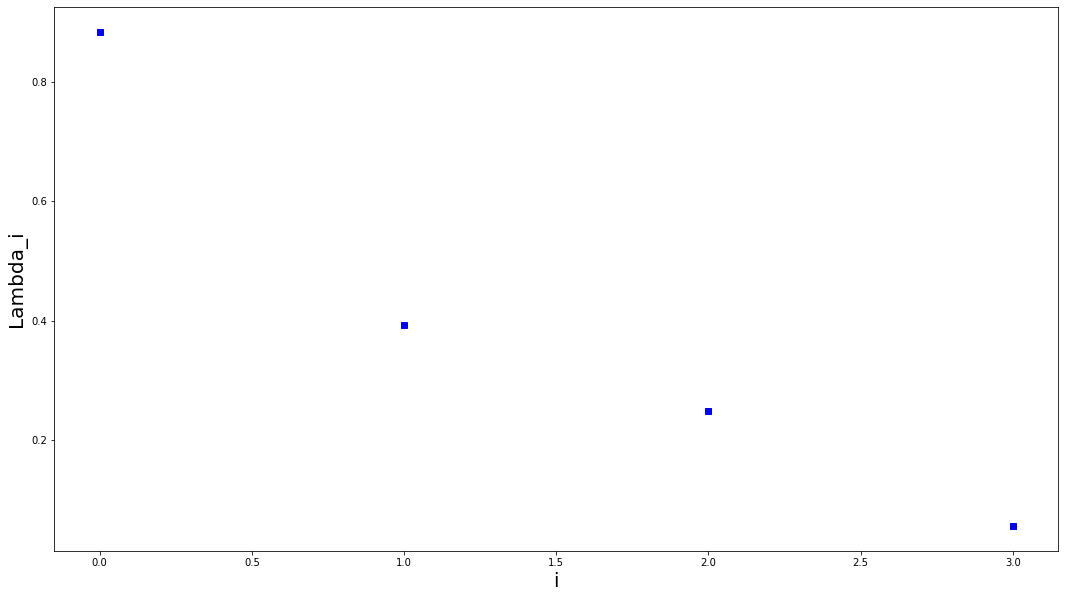

Sweep: 1 of 50, Energy: 0.022349, Bond dim: 4
Sweep: 2 of 50, Energy: 0.022116, Bond dim: 4
Sweep: 3 of 50, Energy: 0.021894, Bond dim: 4
Sweep: 4 of 50, Energy: 0.021682, Bond dim: 4
Sweep: 5 of 50, Energy: 0.021481, Bond dim: 4
Sweep: 6 of 50, Energy: 0.021289, Bond dim: 4
Sweep: 7 of 50, Energy: 0.021107, Bond dim: 4
Sweep: 8 of 50, Energy: 0.020933, Bond dim: 4
Sweep: 9 of 50, Energy: 0.020769, Bond dim: 4
Sweep: 10 of 50, Energy: 0.020612, Bond dim: 4
Sweep: 11 of 50, Energy: 0.020463, Bond dim: 4
Sweep: 12 of 50, Energy: 0.020321, Bond dim: 4
Sweep: 13 of 50, Energy: 0.020187, Bond dim: 4
Sweep: 14 of 50, Energy: 0.020059, Bond dim: 4
Sweep: 15 of 50, Energy: 0.019938, Bond dim: 4
Sweep: 16 of 50, Energy: 0.019824, Bond dim: 4
Sweep: 17 of 50, Energy: 0.019715, Bond dim: 4
Sweep: 18 of 50, Energy: 0.019612, Bond dim: 4
Sweep: 19 of 50, Energy: 0.019515, Bond dim: 4
Sweep: 20 of 50, Energy: 0.019422, Bond dim: 4
Sweep: 21 of 50, Energy: 0.019335, Bond dim: 4
Sweep: 22 of 50, Energ

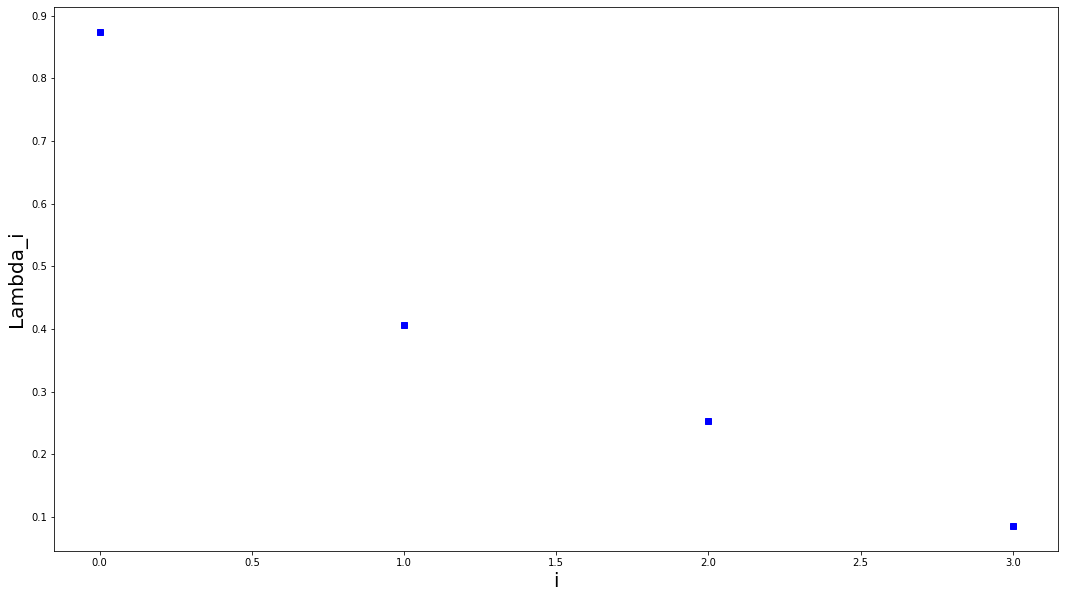

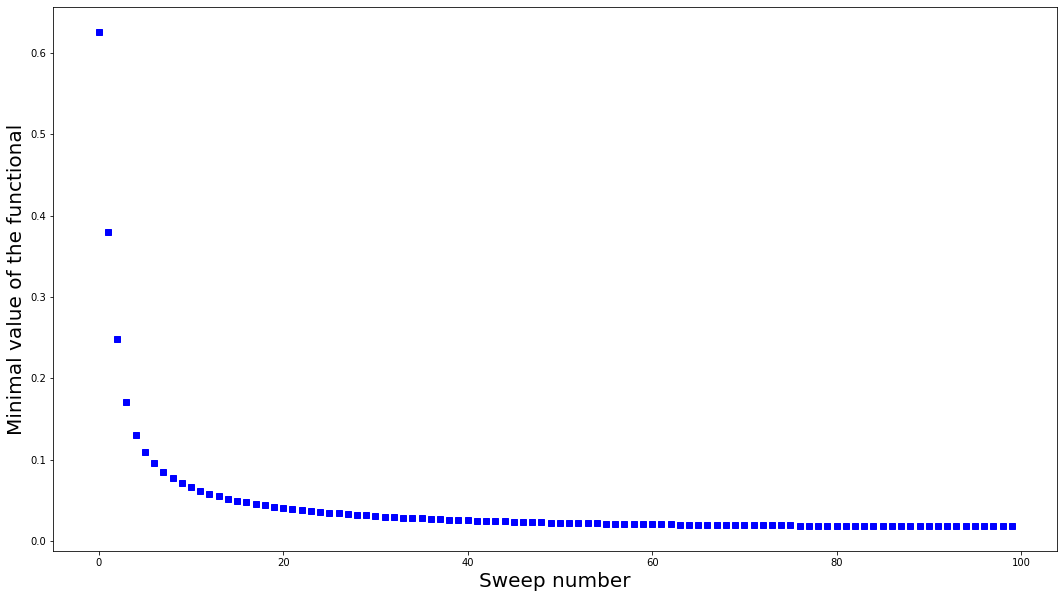

Sweep: 1 of 50, Energy: 0.016162, Bond dim: 8
Sweep: 2 of 50, Energy: 0.015963, Bond dim: 8
Sweep: 3 of 50, Energy: 0.015852, Bond dim: 8
Sweep: 4 of 50, Energy: 0.015767, Bond dim: 8
Sweep: 5 of 50, Energy: 0.015696, Bond dim: 8
Sweep: 6 of 50, Energy: 0.015633, Bond dim: 8
Sweep: 7 of 50, Energy: 0.015540, Bond dim: 8
Sweep: 8 of 50, Energy: 0.015454, Bond dim: 8
Sweep: 9 of 50, Energy: 0.015379, Bond dim: 8
Sweep: 10 of 50, Energy: 0.015317, Bond dim: 8
Sweep: 11 of 50, Energy: 0.015265, Bond dim: 8
Sweep: 12 of 50, Energy: 0.015220, Bond dim: 8
Sweep: 13 of 50, Energy: 0.015182, Bond dim: 8
Sweep: 14 of 50, Energy: 0.015147, Bond dim: 8
Sweep: 15 of 50, Energy: 0.015117, Bond dim: 8
Sweep: 16 of 50, Energy: 0.015090, Bond dim: 8
Sweep: 17 of 50, Energy: 0.015065, Bond dim: 8
Sweep: 18 of 50, Energy: 0.015043, Bond dim: 8
Sweep: 19 of 50, Energy: 0.015023, Bond dim: 8
Sweep: 20 of 50, Energy: 0.015005, Bond dim: 8
Sweep: 21 of 50, Energy: 0.014988, Bond dim: 8
Sweep: 22 of 50, Energ

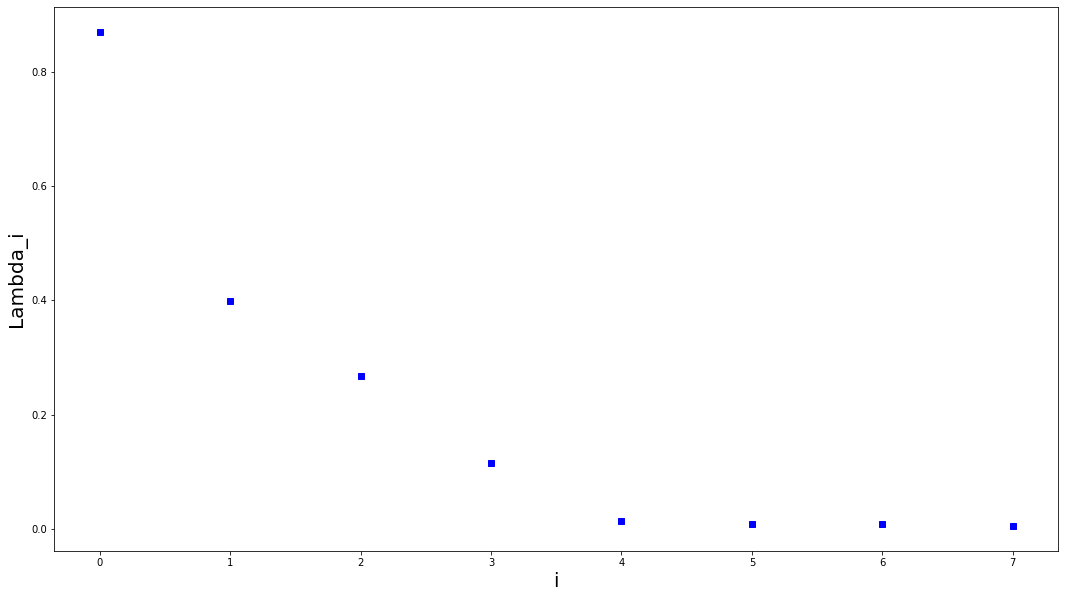

Sweep: 1 of 50, Energy: 0.014815, Bond dim: 8
Sweep: 2 of 50, Energy: 0.014814, Bond dim: 8
Sweep: 3 of 50, Energy: 0.014812, Bond dim: 8
Sweep: 4 of 50, Energy: 0.014811, Bond dim: 8
Sweep: 5 of 50, Energy: 0.014810, Bond dim: 8
Sweep: 6 of 50, Energy: 0.014809, Bond dim: 8
Sweep: 7 of 50, Energy: 0.014808, Bond dim: 8
Sweep: 8 of 50, Energy: 0.014807, Bond dim: 8
Sweep: 9 of 50, Energy: 0.014806, Bond dim: 8
Sweep: 10 of 50, Energy: 0.014806, Bond dim: 8
Sweep: 11 of 50, Energy: 0.014805, Bond dim: 8
Sweep: 12 of 50, Energy: 0.014804, Bond dim: 8
Sweep: 13 of 50, Energy: 0.014803, Bond dim: 8
Sweep: 14 of 50, Energy: 0.014803, Bond dim: 8
Sweep: 15 of 50, Energy: 0.014802, Bond dim: 8
Sweep: 16 of 50, Energy: 0.014802, Bond dim: 8
Sweep: 17 of 50, Energy: 0.014801, Bond dim: 8
Sweep: 18 of 50, Energy: 0.014801, Bond dim: 8
Sweep: 19 of 50, Energy: 0.014800, Bond dim: 8
Sweep: 20 of 50, Energy: 0.014800, Bond dim: 8
Sweep: 21 of 50, Energy: 0.014799, Bond dim: 8
Sweep: 22 of 50, Energ

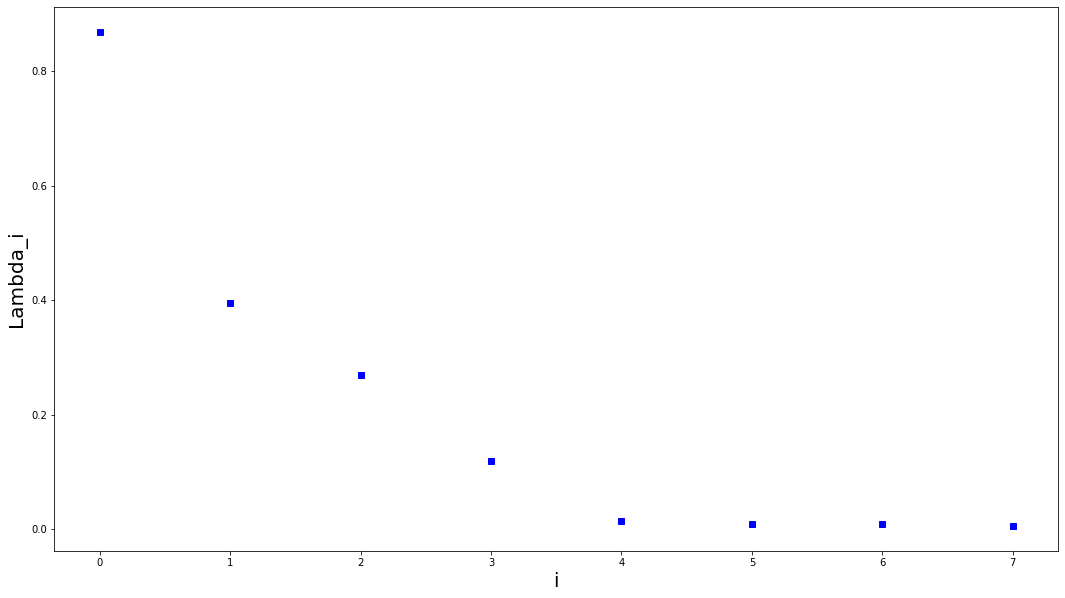

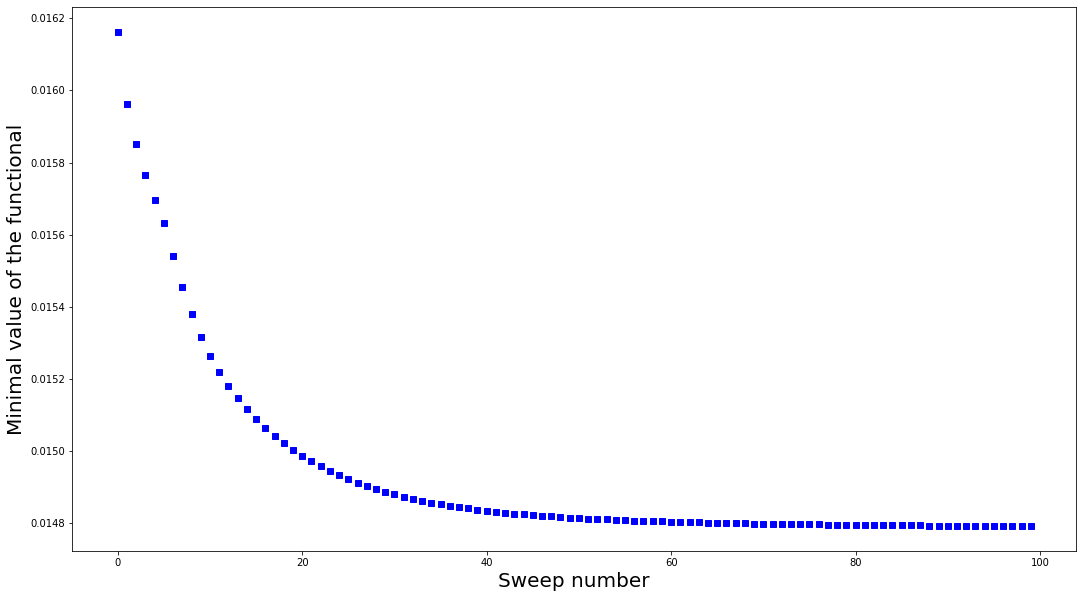

Sweep: 1 of 50, Energy: 0.013088, Bond dim: 16
Sweep: 2 of 50, Energy: 0.012698, Bond dim: 16
Sweep: 3 of 50, Energy: 0.012527, Bond dim: 16
Sweep: 4 of 50, Energy: 0.012424, Bond dim: 16
Sweep: 5 of 50, Energy: 0.012351, Bond dim: 16
Sweep: 6 of 50, Energy: 0.012293, Bond dim: 16
Sweep: 7 of 50, Energy: 0.012243, Bond dim: 16
Sweep: 8 of 50, Energy: 0.012200, Bond dim: 16
Sweep: 9 of 50, Energy: 0.012161, Bond dim: 16
Sweep: 10 of 50, Energy: 0.012126, Bond dim: 16
Sweep: 11 of 50, Energy: 0.012094, Bond dim: 16
Sweep: 12 of 50, Energy: 0.012066, Bond dim: 16
Sweep: 13 of 50, Energy: 0.012040, Bond dim: 16
Sweep: 14 of 50, Energy: 0.012016, Bond dim: 16
Sweep: 15 of 50, Energy: 0.011994, Bond dim: 16
Sweep: 16 of 50, Energy: 0.011973, Bond dim: 16
Sweep: 17 of 50, Energy: 0.011953, Bond dim: 16
Sweep: 18 of 50, Energy: 0.011934, Bond dim: 16
Sweep: 19 of 50, Energy: 0.011917, Bond dim: 16
Sweep: 20 of 50, Energy: 0.011901, Bond dim: 16
Sweep: 21 of 50, Energy: 0.011885, Bond dim: 16
S

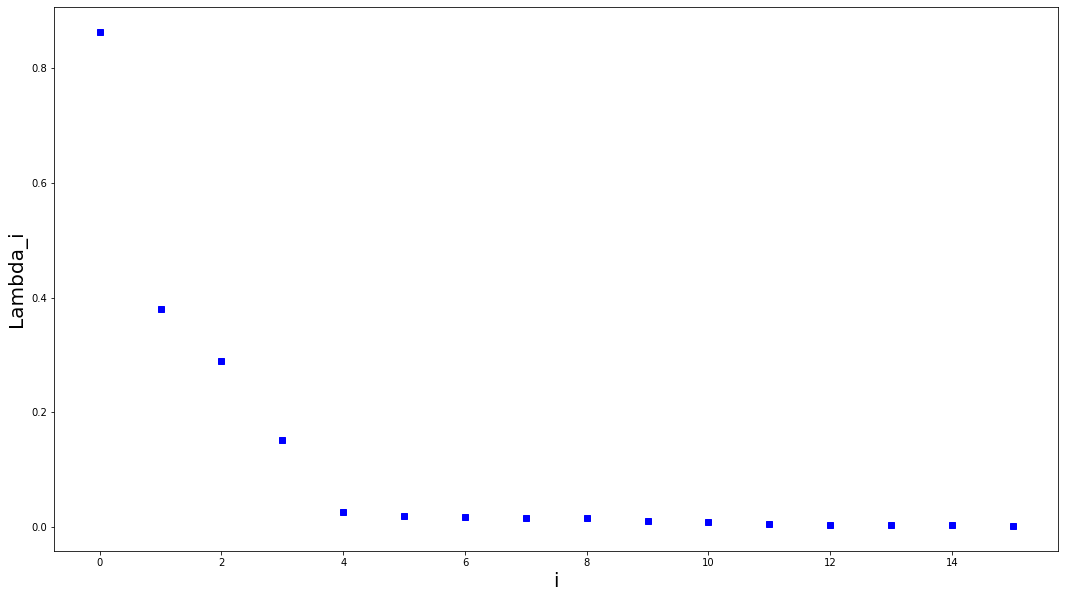

Sweep: 1 of 50, Energy: 0.011621, Bond dim: 16
Sweep: 2 of 50, Energy: 0.011615, Bond dim: 16
Sweep: 3 of 50, Energy: 0.011609, Bond dim: 16
Sweep: 4 of 50, Energy: 0.011604, Bond dim: 16
Sweep: 5 of 50, Energy: 0.011599, Bond dim: 16
Sweep: 6 of 50, Energy: 0.011594, Bond dim: 16
Sweep: 7 of 50, Energy: 0.011590, Bond dim: 16
Sweep: 8 of 50, Energy: 0.011586, Bond dim: 16
Sweep: 9 of 50, Energy: 0.011582, Bond dim: 16
Sweep: 10 of 50, Energy: 0.011578, Bond dim: 16
Sweep: 11 of 50, Energy: 0.011574, Bond dim: 16
Sweep: 12 of 50, Energy: 0.011571, Bond dim: 16
Sweep: 13 of 50, Energy: 0.011568, Bond dim: 16
Sweep: 14 of 50, Energy: 0.011564, Bond dim: 16
Sweep: 15 of 50, Energy: 0.011562, Bond dim: 16
Sweep: 16 of 50, Energy: 0.011559, Bond dim: 16
Sweep: 17 of 50, Energy: 0.011556, Bond dim: 16
Sweep: 18 of 50, Energy: 0.011554, Bond dim: 16
Sweep: 19 of 50, Energy: 0.011552, Bond dim: 16
Sweep: 20 of 50, Energy: 0.011549, Bond dim: 16
Sweep: 21 of 50, Energy: 0.011547, Bond dim: 16
S

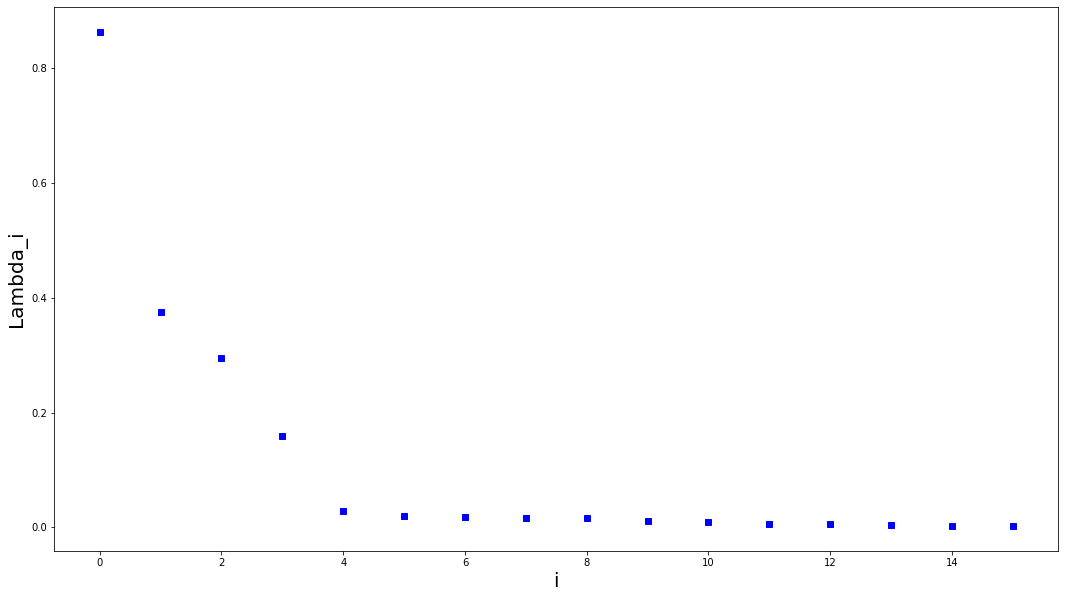

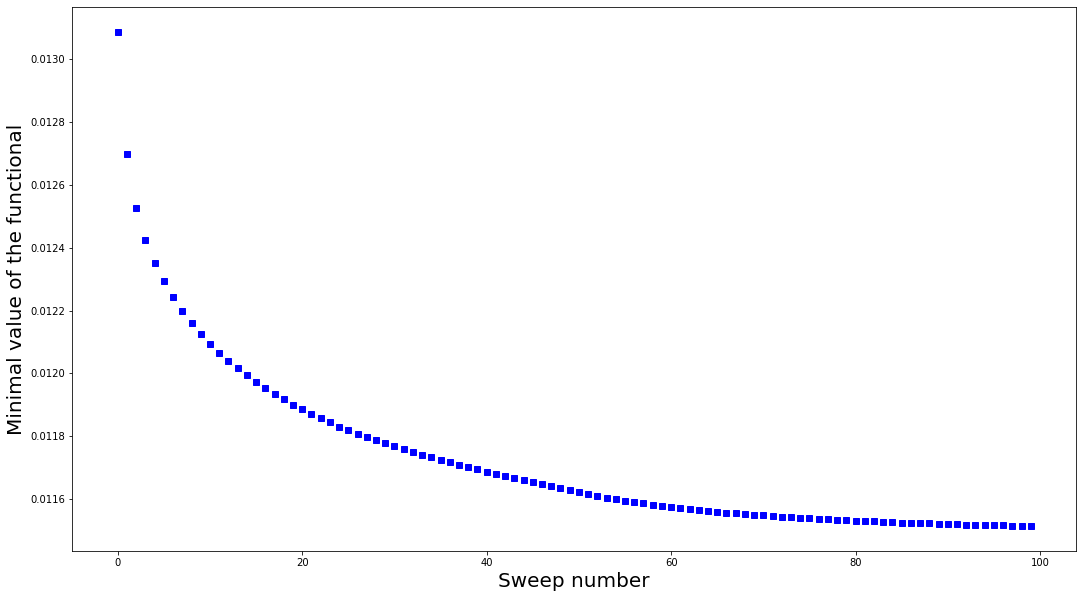

Mininimal value of the functional
0.011513263057416043

peak memory: 196.01 MiB, increment: 36.72 MiB
CPU times: user 16min 55s, sys: 10.2 s, total: 17min 5s
Wall time: 8min 35s


In [32]:
##### -ZZ+hZ+gX model #############
#######################################

##### Set bond dimensions and simulation options
chi = 16
chid = 4
N = 20
#print('The length of the Ising spin chain:',N)
print('H = - ZZ + hZ + gX')

OPTS_numsweeps = 50 # number of DMRG sweeps
OPTS_dispon = 1 # level of output display
OPTS_updateon = True # level of output display
OPTS_maxit = 2 # iterations of Lanczos method
OPTS_krydim = 4 # dimension of Krylov subspace

acc = 50

#printentrhdensmatr()

#printentrlocdensmatr()


h = 0.1
%time %memit CalculateEnergy()
#h = 0.1
#CalculateEnergy()
#h = 0.7
#CalculateEnergy()